In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

I attest that AI was used in the following ways:

ChatGPT was used to brainstorm, draft code and troubleshoot errors, as well as to learn more about clustering methods.

https://chatgpt.com/share/67f5e4e8-9544-8001-b9ff-aacfc6179632

## Preprocessing

In [3]:
url = 'https://media.githubusercontent.com/media/jeswis/crash/refs/heads/main/data/combined_data.csv'

In [4]:
df = pd.read_csv(url)

In [5]:
# Define the bins and labels for the 3-hour intervals
bins = [0, 4, 8, 12, 16, 20, 24]
labels = ['0-3', '4-7', '8-11', '12-15', '16-19', '20-23']

# Apply the binning
df['HOUR_GROUP'] = pd.cut(df['HOUR_IM'], bins=bins, labels=labels, right=False)
# Convert to string (important for OneHotEncoder)
df['HOUR_GROUP'] = df['HOUR_GROUP'].astype(str)

# Drop rows corresponding to unknown
df = df[df['INT_HWY'] != 9]
df = df[df['SOE'] <= 90]

#convert to binary
df['URBANICITY'] = df['URBANICITY'].map({1: 1, 2: 0}) #true if urban
df['ALCHL_IM'] = df['ALCHL_IM'].map({1: 1, 2: 0}) #true if alcohol involved
df['MAXSEV_IM'] = df['MAXSEV_IM'].map({8: 0, 6: 0, 0: 0, 5:1, 1:1, 2:2, 3:3, 4:4}) #in order of increasing severity. 8,6,0 treated as none injured from crash, 5 and 1 treated as same level

# Cap values greater than 3 in number of moving or parked vehicles, or pedestrians
df['VE_FORMS'] = np.where(df['VE_FORMS'] > 3, 3, df['VE_FORMS'])
df['PVH_INVL'] = np.where(df['PVH_INVL'] > 3, 3, df['PVH_INVL'])
df['PEDS'] = np.where(df['PEDS'] > 3, 3, df['PEDS'])

df_sampled = df.sample(frac=0.2, random_state=42)

In [6]:
df_sampled.shape

(17879, 91)

In [7]:
print(df_sampled.columns.tolist())

['CASENUM', 'PSU', 'PSU_VAR', 'PSUSTRAT', 'REGION', 'REGIONNAME', 'URBANICITY', 'URBANICITYNAME', 'STRATUM', 'STRATUMNAME', 'PJ', 'WEIGHT', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PERMVIT', 'MONTH', 'MONTHNAME', 'DAY_WEEK', 'DAY_WEEKNAME', 'WKDY_IM', 'WKDY_IMNAME', 'YEAR', 'YEARNAME', 'HOUR', 'HOURNAME', 'HOUR_IM', 'HOUR_IMNAME', 'MINUTE', 'MINUTENAME', 'MINUTE_IM', 'MINUTE_IMNAME', 'HARM_EV', 'HARM_EVNAME', 'EVENT1_IM', 'EVENT1_IMNAME', 'MAN_COLL', 'MAN_COLLNAME', 'MANCOL_IM', 'MANCOL_IMNAME', 'RELJCT1', 'RELJCT1NAME', 'RELJCT1_IM', 'RELJCT1_IMNAME', 'RELJCT2', 'RELJCT2NAME', 'RELJCT2_IM', 'RELJCT2_IMNAME', 'TYP_INT', 'TYP_INTNAME', 'REL_ROAD', 'REL_ROADNAME', 'WRK_ZONE', 'WRK_ZONENAME', 'LGT_COND', 'LGT_CONDNAME', 'LGTCON_IM', 'LGTCON_IMNAME', 'WEATHER', 'WEATHERNAME', 'WEATHR_IM', 'WEATHR_IMNAME', 'SCH_BUS', 'SCH_BUSNAME', 'INT_HWY', 'INT_HWYNAME', 'MAX_SEV', 'MAX_SEVNAME', 'MAXSEV_IM', 'MAXSEV_IMNAME', 'NUM_INJ', 'NUM_INJNAME', 'NO_INJ_IM', 'NO_INJ_IMNAME', 'ALCO

'CASENUM', 
'PSU', = primary sampling unit
'PSU_VAR', = for variance estimation
'PSUSTRAT', = psu stratum
'REGION', 'REGIONNAME', = South, North, etc
'URBANICITY', 'URBANICITYNAME', = rural, urban
'STRATUM', 'STRATUMNAME', =  category in which the police report 
was originally listed in the PARSE Program
'PJ', = police jurisdiction
'WEIGHT', = case weight
'PEDS', = number of nonoccupants in crash 
'PERNOTMVIT', = number of nonmotorists in crash who were moving
'VE_TOTAL', =  number of the motor vehicles in the crash
'VE_FORMS', = number of motor vehicles in crash who were moving
'PVH_INVL', = number of parked and working motor vehicles 
involved in the cras

'PERMVIT',= number of motorists in the crash 
'MONTH', 'MONTHNAME', 
'DAY_WEEK', 'DAY_WEEKNAME', 
'WKDY_IM', 'WKDY_IMNAME', 
'YEAR', 'YEARNAME', 
'HOUR', 'HOURNAME', 
'HOUR_IM', 'HOUR_IMNAME', 
'MINUTE', 'MINUTENAME', 
'MINUTE_IM', 'MINUTE_IMNAME', 
'HARM_EV', 'HARM_EVNAME',=  the first injury- or damage-producing event of the crash 
'EVENT1_IM', 'EVENT1_IMNAME', 
'MAN_COLL', 'MAN_COLLNAME',=  manner of collision (orientation in-transport or not in transport) 
'MANCOL_IM', 'MANCOL_IMNAME'
'RELJCT1', 'RELJCT1NAME',= binary relation to junction, whether the crash occured within an interchange area 
'RELJCT1_IM', 'RELJCT1_IMNAME', 
'RELJCT2', 'RELJCT2NAME',=  specific relation to junction, the crash’s location with respect to  interchange areas 
'RELJCT2_IM', 'RELJCT2_IMNAME', 
'TYP_INT', 'TYP_INTNAME'= type of intersection, 
'REL_ROAD', 'REL_ROADNAME'= relation to trafficway,  the location of the crash as it relates to its position 
within or outside the trafficway, 
'WRK_ZONE', 'WRK_ZONENAME= whether crash occured in proximity of work zone and if so what type', 
'LGT_COND', 'LGT_CONDNAME= lighting conditions', 
'LGTCON_IM', 'LGTCON_IMNAME', 
'WEATHER', 'WEATHERNAME= weather conditions', 
'WEATHR_IM', 'WEATHR_IMNAME', 
'SCH_BUS', 'SCH_BUSNAME= binary if school bus related', 
'INT_HWY', 'INT_HWYNAME= binary if on interstate highway', 
'MAX_SEV', 'MAX_SEVNAME= level of severity (categorical)', 
'MAXSEV_IM', 'MAXSEV_IMNAME', 
'NUM_INJ', 'NUM_INJNAME= the number of people injured in the crash', 
'NO_INJ_IM', 'NO_INJ_IMNAME', 
'ALCOHOL', 'ALCOHOLNAME= if alchohol use or no applicable person (such as cases with no driver)', 
'ALCHL_IM', 'ALCHL_IMNAME', 
'EVENTNUM', 
'VNUMBER1', 
'AOI1', 'AOI1NAME= impact point on vehicle', 
'SOE', 'SOENAME', 
'VNUMBER2', 'VNUMBER2NAME', 
'AOI2', 'AOI2NAME= impact point on the other vehicle'

In [9]:
print(df['EVENT1_IMNAME'].unique())

['Motor Vehicle In-Transport' 'Tree (Standing Only)' 'Guardrail Face'
 'Parked Motor Vehicle' 'Live Animal' 'Culvert' 'Curb'
 'Utility Pole/Light Support' 'Ditch' 'Cable Barrier'
 'Concrete Traffic Barrier' 'Pedestrian' 'Embankment' 'Guardrail End'
 'Pedalcyclist' 'Rollover/Overturn' 'Traffic Sign Support'
 'Motor Vehicle In-Transport Strikes or is Struck by Cargo, Persons or Objects Set-in-Motion from/by Another Motor Vehicle In Transport'
 'Unknown Fixed Object' 'Mail Box' 'Shrubbery'
 'Non-Motorist on Personal Conveyance' 'Boulder'
 'Impact Attenuator/Crash Cushion' 'Building' 'Other Fixed Object'
 'Thrown or Falling Object' 'Wall' 'Other Object (not fixed)'
 'Cargo/Equipment Loss, Shift, or Damage [harmful]'
 'Working Motor Vehicle' 'Fire Hydrant' 'Snow Bank'
 'Jackknife (harmful to this vehicle)' 'Fence' 'Fell/Jumped from Vehicle'
 'Ground' 'Post, Pole or Other Supports' 'Bridge Rail (Includes parapet)'
 'Traffic Signal Support' 'Bridge Pier or Support'
 'Ridden Animal or Animal D

In [10]:
continuous_columns = ['MAXSEV_IM', 'VE_FORMS', 'PVH_INVL', 'PEDS']
#onehotencoding categorical variables
categorical_columns = ['REGION', 'WKDY_IM', 'HOUR_GROUP', 'EVENT1_IM', 'MANCOL_IM', 'TYP_INT', 'REL_ROAD', 'RELJCT2','WRK_ZONE', 'LGTCON_IM', 'WEATHR_IM', 'SOE']
# labeling binary variables
bin_columns = ['RELJCT1_IM', 'URBANICITY', 'ALCHL_IM', 'SCH_BUS', 'INT_HWY']
#dropping unused columns
df_filtered = df_sampled[categorical_columns + bin_columns +continuous_columns].copy()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns), #drop first, 
        ('num', StandardScaler(), continuous_columns) #minmaxscaler preferred for 0 to 1
    ],
    remainder='passthrough'  # keeps binary columns as-is
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(df_filtered)

# Convert sparse matrix to dense (this is the critical part!)
X_processed = X_processed.toarray()  # Convert sparse matrix to dense numpy array

In [11]:
print(np.max(X_processed), np.min(X_processed))

10.041765668026361 -1.0402438677657735


In [12]:
# Initialize an empty dictionary to store mappings
mapping_dicts = {}

# 1. Loop over all categorical columns to create mappings
for col in categorical_columns:
    if col in df.columns:  # Check if the base column exists
        # Create the corresponding 'IMNAME' column by appending 'NAME'
        imname_col = col + 'NAME'  # Column with '_IMNAME'
        
        if imname_col in df.columns:  # Check if the '_IMNAME' column exists
            # Create the mapping from unique '_IM' values to the corresponding '_IMNAME'
            mapping_dicts[col] = dict(zip(df[col].unique(), df[imname_col].unique()))
        else:
            # If there's no '_IMNAME' column, store an empty mapping
            mapping_dicts[col] = {}

# 2. Print the mappings for each column
for col in categorical_columns:
    if col in mapping_dicts and mapping_dicts[col]:
        print(f"\nMapping for {col}:")
        # Print each category number and its corresponding name
        for num, name in mapping_dicts[col].items():
            print(f"{num} -> {name}")
    else:
        print(f"\nNo mapping found for {col}")


Mapping for REGION:
3 -> South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)
2 -> Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)
4 -> West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)
1 -> Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)

Mapping for WKDY_IM:
7 -> Saturday
1 -> Sunday
2 -> Monday
3 -> Tuesday
4 -> Wednesday
5 -> Thursday
6 -> Friday

No mapping found for HOUR_GROUP

Mapping for EVENT1_IM:
12 -> Motor Vehicle In-Transport
42 -> Tree (Standing Only)
24 -> Guardrail Face
14 -> Parked Motor Vehicle
11 -> Live Animal
32 -> Culvert
33 -> Curb
30 -> Utility Pole/Light Support
34 -> Ditch
57 -> Cable Barrier
25 -> Concrete Traffic Barrier
8 -> Pedestrian
35 -> Embankment
52 -> Guardrail End
9 -> Pedalcyclist
1 -> Rollover/Overturn
59 -> Traffic Sign Support
54 -> Motor Vehicle In-Transport Strikes or is Struck by Cargo, Persons or Objects Set-in-Motion from/by Another Motor Vehicle In Transport
93 -> Unknown Fixed Object
53 -> Mail Box
4

## Perform Autoencoding to compress data

In [14]:
# Step 2: Define Regular Autoencoder (AE)
input_dim = X_processed.shape[1]
latent_dim = 47

def build_autoencoder(input_dim, latent_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(latent_dim, activation='relu')(encoded)
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)
    
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(input_dim, latent_dim)

# Step 3: Train the Autoencoder
autoencoder.fit(X_processed, X_processed, epochs=20, batch_size=128, shuffle=True)

# Step 4: Extract latent space (encoded features)
latent_embeddings = encoder.predict(X_processed)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3755  
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: -5.2391
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: -214.0877
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1589.3278
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: -5815.1792
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -14878.5400  
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: -30860.9219
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -56401.5469  
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -97195.9844  
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: -151213.3281
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: -226923.8906 
Epoch 12/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -310761.4062  
Epoch 13/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -436979.7812  
Epoch 14/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [15]:
X_reconstructed = autoencoder.predict(X_processed)
reconstruction_errors = np.mean((X_processed - X_reconstructed) ** 2, axis=1)

# Optionally, get average reconstruction error across all samples
mean_reconstruction_error = np.mean(reconstruction_errors)

print("Mean Reconstruction Error:", mean_reconstruction_error)

559/559 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
Mean Reconstruction Error: 0.08229672566385307


In [16]:
latent_embeddings = StandardScaler().fit_transform(latent_embeddings) #scaled autoencoder output again

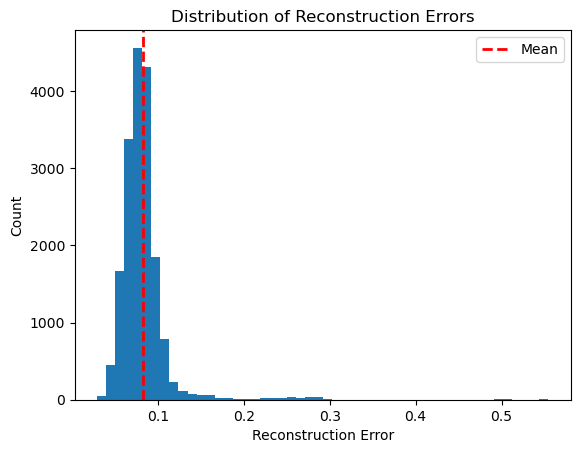

In [17]:
plt.hist(reconstruction_errors, bins=50)
plt.axvline(reconstruction_errors.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()

## Clustering
KMeans, GMM, and DBscans

### Refining KMeans Parameters

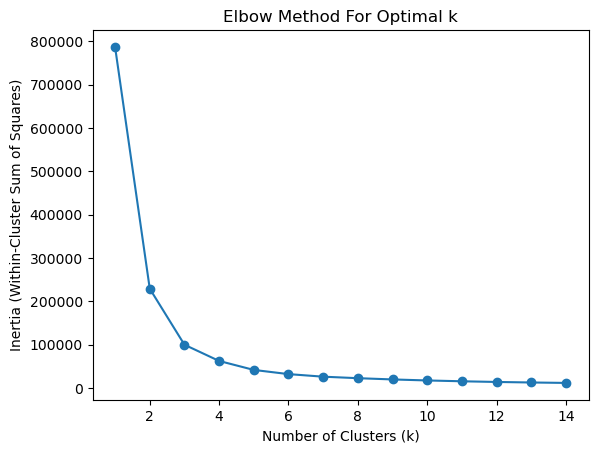

In [20]:
inertia = []
K_range = range(1, 15)

# Elbow method to find the optimal k
for k in K_range:
    # Fit the pipeline (includes preprocessing and KMeans)
    kmeansb=KMeans(n_clusters=k, random_state=42, n_init=20).fit(latent_embeddings)
    # Collect the inertia (sum of squared distances of samples to their closest cluster center)
    inertia.append(kmeansb.inertia_)

# Plot the inertia for each k to determine the "elbow"
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
kmeans.fit(latent_embeddings)

clusters = kmeans.labels_

# Calculate silhouette score
sil_score = silhouette_score(latent_embeddings, clusters)
print(f'Silhouette Score: {sil_score}')

# Calculate Davies-Bouldin Index (DBI)
dbi = davies_bouldin_score(latent_embeddings, clusters)
print(f'Davies-Bouldin Index (DBI): {dbi}')

Silhouette Score: 0.578916072845459
Davies-Bouldin Index (DBI): 0.5319906264819864


Fairly well separated and distinct clusters.

### Results

In [24]:
# Step 1: Make a copy of the preprocessed data
df_filtered_copy = df_filtered.copy()

# Add the kmeans cluster labels to the copy
df_filtered_copy['kmeans_cluster'] = clusters  # clusters are the labels from kmeans

# Step 3: Group by cluster and calculate percentages for each category within a feature
cluster_percentage = {}

for feature in df_filtered:
    # Calculate counts of each category per cluster
    feature_counts = df_filtered_copy.groupby(['kmeans_cluster', feature]).size().unstack(fill_value=0)
    
    # Calculate the total number of samples in each cluster
    cluster_totals = feature_counts.sum(axis=1)
    
    # Calculate percentage per feature category
    feature_percentages = feature_counts.divide(cluster_totals, axis=0) * 100
    
    # Store the result for each feature
    cluster_percentage[feature] = feature_percentages

# Step 4: Display the result (percentage table)
for feature, percentage in cluster_percentage.items():
    print(f"\nPercentage of each category for feature: {feature}")
    print(percentage)


Percentage of each category for feature: REGION
REGION                  1          2          3          4
kmeans_cluster                                            
0                8.855109  16.950175  59.971046  14.223670
1               18.973781  18.550888  40.964195  21.511136
2               10.623862  20.039715  50.835678  18.500745

Percentage of each category for feature: WKDY_IM
WKDY_IM                 1          2          3          4          5  \
kmeans_cluster                                                          
0                7.564242  14.645916  14.718301  16.141875  16.443479   
1               19.340288  12.574006  12.376656  12.066535  12.263885   
2               16.134370  13.519775  13.023333  12.526891  12.725467   

WKDY_IM                 6          7  
kmeans_cluster                        
0               17.686090  12.800097  
1               14.152805  17.225825  
2               15.389707  16.680457  

Percentage of each category for feature: HOU

### GM

In [26]:

# List of hyperparameters to test
n_components_values = [3,4,5]  # Different number of components (clusters)
covariance_types = ['full', 'diag', 'spherical']  # Different covariance types
init_params_values = ['kmeans', 'random']  # Initialization method

best_sil_score = -1  # Initialize to track the best Silhouette Score
best_dbi_score = float('inf')  # Initialize to track the best DBI Score

# Loop through different combinations of parameters
for n_components in n_components_values:
    for cov_type in covariance_types:
        for init_param in init_params_values:
            
            # Fit the GMM model with the current hyperparameters
            gmm = GaussianMixture(n_components=n_components, 
                                  covariance_type=cov_type, 
                                  init_params=init_param, 
                                  random_state=42)
            
            # Fit the GMM to the data
            gmm.fit(latent_embeddings)
            
            # Predict the cluster labels
            cluster_labels = gmm.predict(latent_embeddings)
            
            # Evaluate Silhouette Score (only if more than 1 cluster exists)
            if len(set(cluster_labels)) > 1:
                sil_score = silhouette_score(latent_embeddings, cluster_labels)
                print(f"Silhouette Score for GMM (n={n_components}, cov_type={cov_type}, init={init_param}): {sil_score}")
                
                # Track the best Silhouette Score
                if sil_score > best_sil_score:
                    best_sil_score = sil_score
                    best_sil_params = (n_components, cov_type, init_param)
            
            # Evaluate Davies-Bouldin Index (DBI)
            dbi_score = davies_bouldin_score(latent_embeddings, cluster_labels)
            print(f"Davies-Bouldin Index for GMM (n={n_components}, cov_type={cov_type}, init={init_param}): {dbi_score}")
            
            # Track the best DBI score
            if dbi_score < best_dbi_score:
                best_dbi_score = dbi_score
                best_dbi_params = (n_components, cov_type, init_param)

# Output the best performing GMM configurations
print(f"\nBest Silhouette Score: {best_sil_score} with params: {best_sil_params}")
print(f"Best Davies-Bouldin Index: {best_dbi_score} with params: {best_dbi_params}")

Silhouette Score for GMM (n=3, cov_type=full, init=kmeans): 0.15030105412006378
Davies-Bouldin Index for GMM (n=3, cov_type=full, init=kmeans): 0.9926852960489589
Silhouette Score for GMM (n=3, cov_type=full, init=random): 0.3944321274757385
Davies-Bouldin Index for GMM (n=3, cov_type=full, init=random): 1.6648079788834134
Silhouette Score for GMM (n=3, cov_type=diag, init=kmeans): 0.5691331028938293
Davies-Bouldin Index for GMM (n=3, cov_type=diag, init=kmeans): 0.5434845352117795
Silhouette Score for GMM (n=3, cov_type=diag, init=random): 0.5676645636558533
Davies-Bouldin Index for GMM (n=3, cov_type=diag, init=random): 0.5450036621772182
Silhouette Score for GMM (n=3, cov_type=spherical, init=kmeans): 0.5628468990325928
Davies-Bouldin Index for GMM (n=3, cov_type=spherical, init=kmeans): 0.5494416377734056
Silhouette Score for GMM (n=3, cov_type=spherical, init=random): 0.5544261336326599
Davies-Bouldin Index for GMM (n=3, cov_type=spherical, init=random): 0.5568149425415302
Silhoue

In [27]:
gmm = GaussianMixture(n_components=best_dbi_params[0], random_state=42, covariance_type=best_dbi_params[1], init_params=best_dbi_params[2]).fit(latent_embeddings)
aim = gmm.aic(latent_embeddings)
clustersgmm = gmm.predict(latent_embeddings)
# Predict the soft labels (probabilities of belonging to each cluster)
probabilitiesgmm = gmm.predict_proba(latent_embeddings)
# Convert soft labels to hard labels by choosing the cluster with the highest probability
hard_labels = np.argmax(probabilitiesgmm, axis=1)
# Calculate the Silhouette Score using the hard labels
sil_scoregmm = silhouette_score(latent_embeddings, hard_labels)
print(f"Silhouette Score for GMM: {sil_scoregmm}")
print(f"AIM score:", aim)
# Calculate Davies-Bouldin Index (DBI) for GMM
dbi_gmm = davies_bouldin_score(latent_embeddings, hard_labels)
print(f'Davies-Bouldin Index (DBI) for GMM: {dbi_gmm}')

Silhouette Score for GMM: 0.5691331028938293
AIM score: -74362.7558972581
Davies-Bouldin Index (DBI) for GMM: 0.5434845352117795


Note: Silhouette Score isn't the most accurate for GMM, as it assumes spherical clusters of equal variance and measures, which doesn't necessarily apply to GMM, as they can be more elliptical and can overlap. Still, this shows that there is relatively clear separation between clusters.

The DBI score is slightly lower than K-means, showing that has slightly more compact clusters.


In [29]:
# Assuming KMeans clusters are already computed and stored in `clusters`
# Create a copy of the DataFrame
df_filtered_copygmm = df_filtered.copy()

# Add the GMM cluster labels to the DataFrame (instead of KMeans clusters)
df_filtered_copygmm['gmm_cluster'] = clustersgmm  # clustersgmm are the labels from GMM

# Step 3: Calculate percentages for each categorical feature within each GMM cluster
cluster_percentage = {}

for feature in categorical_columns:
    # Calculate counts of each category per cluster
    feature_counts = df_filtered_copygmm.groupby(['gmm_cluster', feature]).size().unstack(fill_value=0)
    
    # Calculate the total number of samples in each cluster
    cluster_totals = feature_counts.sum(axis=1)
    
    # Calculate percentage per feature category
    feature_percentages = feature_counts.divide(cluster_totals, axis=0) * 100
    
    # Store the result for each feature
    cluster_percentage[feature] = feature_percentages

# Step 4: Display the result (percentage table)
for feature, percentage in cluster_percentage.items():
    print(f"\nPercentage of each category for feature: {feature}")
    print(percentage)


Percentage of each category for feature: REGION
REGION               1          2          3          4
gmm_cluster                                            
0            10.053252  20.348556  51.363563  18.234630
1             8.864194  16.681742  60.395400  14.058664
2            18.767436  18.310931  41.567335  21.354299

Percentage of each category for feature: WKDY_IM
WKDY_IM              1          2          3          4          5          6  \
gmm_cluster                                                                     
0            15.200904  13.732451  13.119251  12.538325  13.006293  15.668872   
1             7.378214  14.640134  14.846879  16.319938  16.552526  17.702546   
2            19.655085  12.503170  12.274918  12.249556  12.173472  14.126300   

WKDY_IM              7  
gmm_cluster             
0            16.733904  
1            12.559762  
2            17.017499  

Percentage of each category for feature: HOUR_GROUP
HOUR_GROUP         0-3      12-15    

## Refining DBScan

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

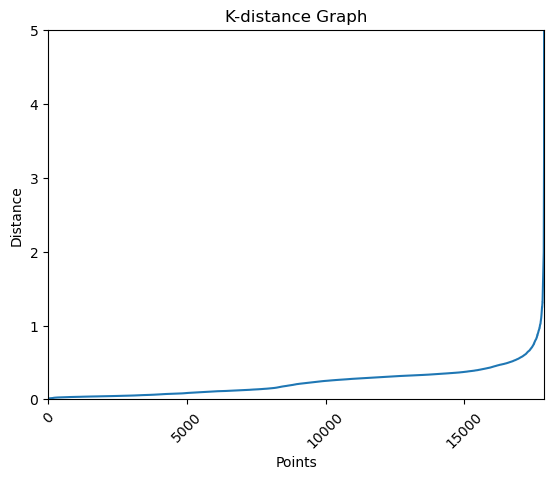

In [32]:
# Try different values of min_samples (from the rule of thumb or by experimentation)
min_samples = 75

# Compute the k-distance graph (k=5 here, but you can adjust it)
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(latent_embeddings) 
distances, indices = neighbors_fit.kneighbors(latent_embeddings)

# Sort the distances (to plot them)
distances = np.sort(distances[:, -1], axis=0)

# Plot the k-distance graph
plt.plot(distances)
plt.title("K-distance Graph")
plt.xlabel("Points")
plt.ylabel("Distance")

# Dynamically adjust xlim based on the number of points
plt.xlim(16, len(distances))  # Set x-axis limits from 0 to the number of points

# Adjust the ylim based on your data
plt.ylim(0, 5)  # Set y-axis from 0 to a little above the maximum distance

# Optional: Set xticks dynamically
plt.xticks(np.arange(0, len(distances), step=5000))  # Adjust step as needed
plt.xticks(rotation=45)
plt.show()


In [33]:
# Set the epsilon value from the k-distance graph elbow
eps_value = [0.02,0.03, 0.05]

# Assume X_reduced is your reduced feature space (e.g., after PCA or t-SNE)
for eps_value in eps_value:
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
    
    # Fit DBSCAN to the preprocessed data
    clustersdba = dbscan.fit_predict(latent_embeddings)
    
    # Filter out noise points (those with label -1)
    non_noise_points = latent_embeddings[clustersdba != -1]
    non_noise_labels = clustersdba[clustersdba != -1]

    # Evaluate the clustering using silhouette score (only if there are more than 1 cluster)
    if len(set(non_noise_labels)) > 1:  # Silhouette score is meaningful only for more than 1 cluster
        sil_score = silhouette_score(non_noise_points, non_noise_labels)
        print(f"Silhouette Score for eps={eps_value}: {sil_score}")
        dbi_score = davies_bouldin_score(non_noise_points, non_noise_labels)
        print(f"Davies-Bouldin Index for eps={eps_value}: {dbi_score}")
    else:
        print(f"DBSCAN with ep={eps_value} found only one cluster or noise.")

    # Add cluster labels to the dataframe
    df_copyba = df_filtered.copy()
    df_copyba[f'cluster_eps_{eps_value}'] = clustersdba

Silhouette Score for eps=0.02: 0.7996272444725037
Davies-Bouldin Index for eps=0.02: 0.32270447357012344
Silhouette Score for eps=0.03: 0.7815784215927124
Davies-Bouldin Index for eps=0.03: 0.29081913691657807
Silhouette Score for eps=0.05: 0.5830442309379578
Davies-Bouldin Index for eps=0.05: 0.326634017777539


In [90]:
np.unique(clustersdba)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [72]:
# Set epsilon value
eps_value = 0.07

# Fit DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
clustersdb = dbscan.fit_predict(latent_embeddings)

# Filter out noise points
non_noise_points = latent_embeddings[clustersdb != -1]
non_noise_labels = clustersdb[clustersdb != -1]

# Evaluate clustering
if len(set(non_noise_labels)) > 1:
    sil_score = silhouette_score(non_noise_points, non_noise_labels)
    dbi_score = davies_bouldin_score(non_noise_points, non_noise_labels)
    print(f"Silhouette Score (eps={eps_value}): {sil_score:.4f}")
    print(f"Davies-Bouldin Index (eps={eps_value}): {dbi_score:.4f}")
else:
    print(f"DBSCAN with eps={eps_value} found only one cluster or noise.")

# Add cluster labels to the dataframe
df_copyb = df_filtered.copy()
df_copyb[f'cluster_eps_{eps_value}'] = clustersdb

Silhouette Score (eps=0.07): 0.5192
Davies-Bouldin Index (eps=0.07): 0.4181


Note that DBscans classifies some noise as -1, which can throw off silhouette score. Silhouette score does not account for density.

min_samples=12 is most optimal, with sil score and DBI score that implies fairly good clustering. Sil score shows reasonable cluster quality, but DBScans has the best DBI among the models, indicating that DBSCAN has the best separation between clusters in terms of internal compactness and distance between clusters.

In [75]:
# Assuming KMeans clusters are already computed and stored in `clusters`
# Create a copy of the DataFrame
df_filtered_copydb = df_filtered.copy()

# Add the GMM cluster labels to the DataFrame (instead of KMeans clusters)
df_filtered_copydb['gmm_cluster'] = clustersdb

# Step 3: Calculate percentages for each categorical feature within each GMM cluster
cluster_percentage = {}

for feature in categorical_columns:
    # Calculate counts of each category per cluster
    feature_counts = df_filtered_copydb.groupby(['gmm_cluster', feature]).size().unstack(fill_value=0)
    
    # Calculate the total number of samples in each cluster
    cluster_totals = feature_counts.sum(axis=1)
    
    # Calculate percentage per feature category
    feature_percentages = feature_counts.divide(cluster_totals, axis=0) * 100
    
    # Store the result for each feature
    cluster_percentage[feature] = feature_percentages

# Step 4: Display the result (percentage table)
for feature, percentage in cluster_percentage.items():
    print(f"\nPercentage of each category for feature: {feature}")
    print(percentage)


Percentage of each category for feature: REGION
REGION               1          2          3          4
gmm_cluster                                            
-1           11.088926  19.228997  51.244049  18.438028
 0           20.547945  15.981735  57.077626   6.392694
 1            6.846610  15.997367  63.528637  13.627386
 2            0.800000  24.000000  68.800000   6.400000
 3           18.087855  20.155039  32.816537  28.940568
 4           14.886165  16.287215  56.129597  12.697023
 5            6.514658  13.029316  70.358306  10.097720
 6           43.478261   8.074534  33.540373  14.906832
 7           11.428571  14.821429  63.571429  10.178571
 8           20.379147  11.374408  46.919431  21.327014
 9            1.960784  19.607843  72.549020   5.882353
 10          12.195122   4.878049  75.609756   7.317073
 11          14.285714  33.333333  42.857143   9.523810

Percentage of each category for feature: WKDY_IM
WKDY_IM              1          2          3          4      

## Visualization
Note that high dimensional data is not perfectly represented in 2d or 3d space. The techniques used to obtain these visualizations of the clusters were not the same dimensionality reduction technique used before clustering. Though these visualizations are imperfect, they are still valuable to observe.

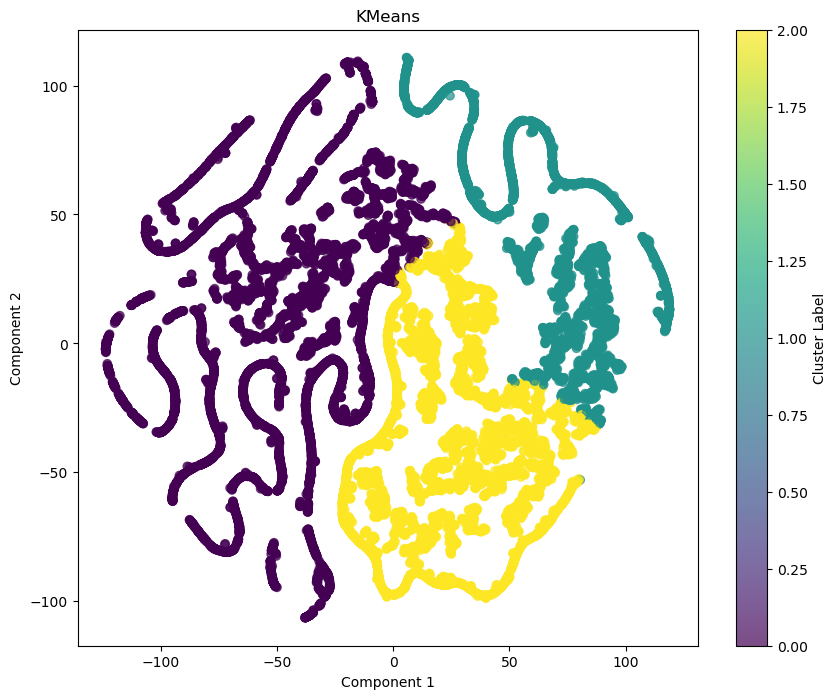

In [78]:
# Reduce the latent space to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_2D = tsne.fit_transform(latent_embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.7)
plt.title(f"KMeans")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

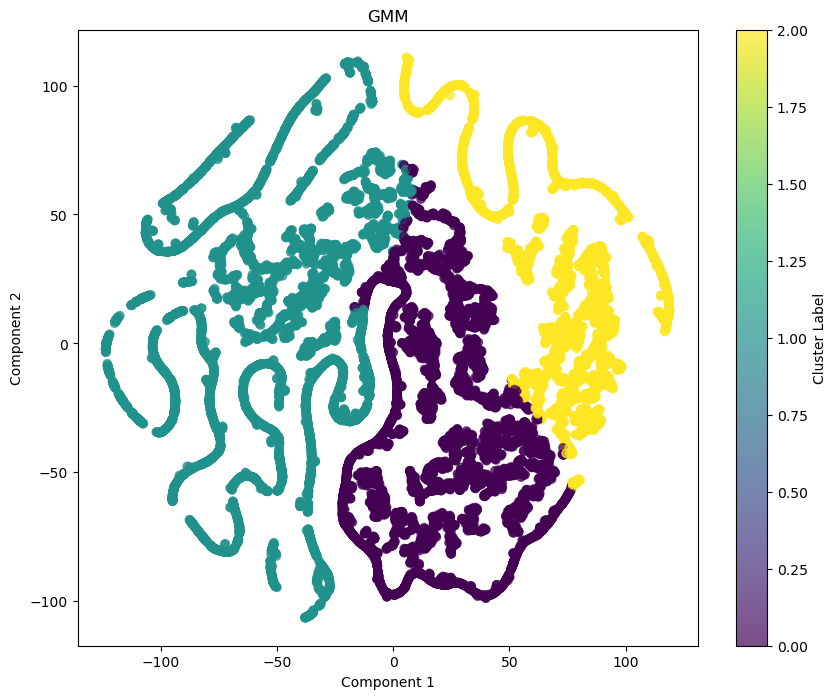

In [79]:
# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=clustersgmm, cmap='viridis', marker='o', alpha=0.7)
plt.title(f"GMM")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

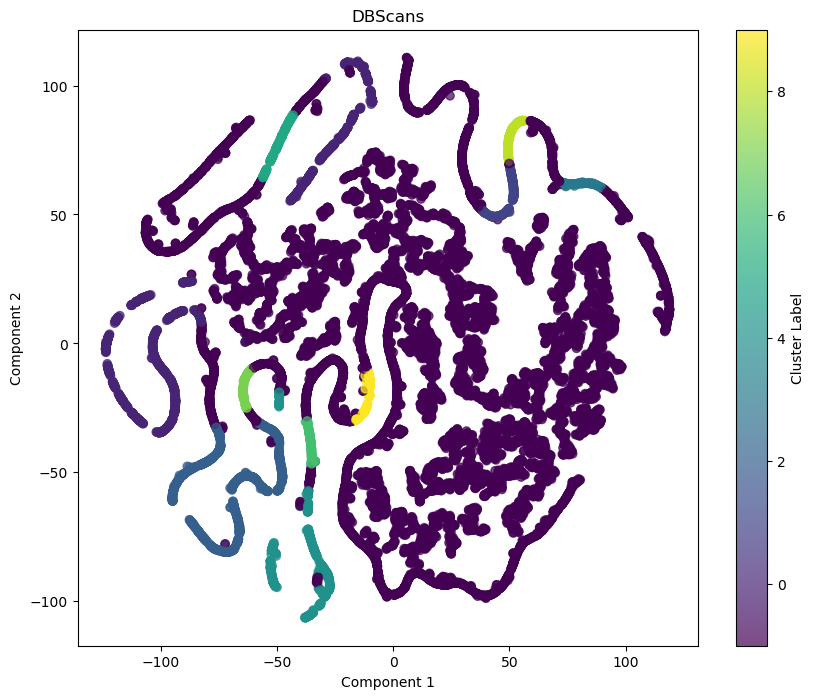

In [80]:
# DBScans with 'ideal' parameters
plt.figure(figsize=(10, 8))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=clustersdba, cmap='viridis', marker='o', alpha=0.7)
plt.title(f"DBScans")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

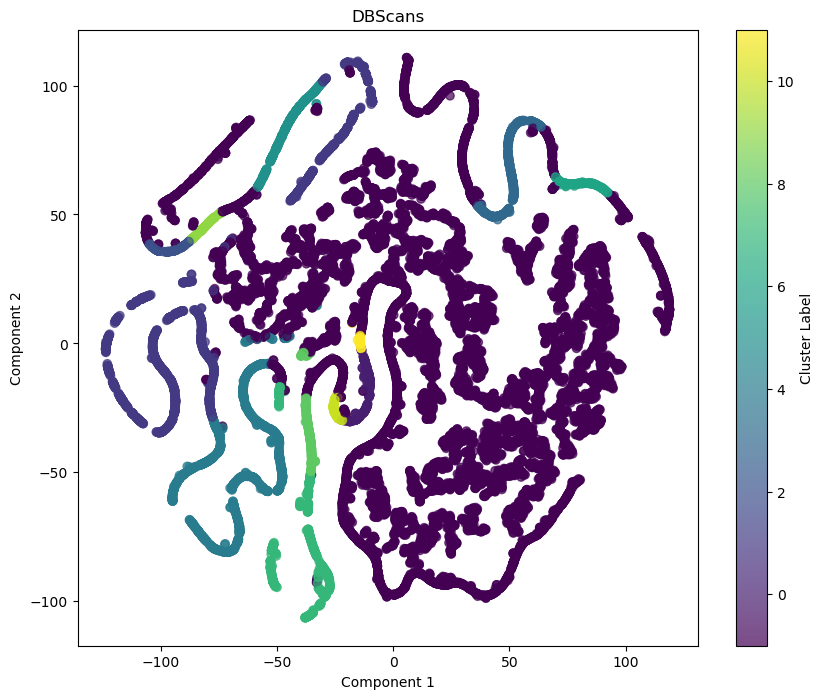

In [81]:
# DBScans with adjusted parameters
plt.figure(figsize=(10, 8))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=clustersdb, cmap='viridis', marker='o', alpha=0.7)
plt.title(f"DBScans")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster Label")
plt.show()